In [1]:
from xflowrl.util.util import plot_to_image, plot_xfer_heatmap
from collections import OrderedDict
import seaborn as sns
import json
import pandas as pd

/home/sean/.pyenv/versions/3.7.0/envs/xflow/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Utils

In [80]:
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_figure(name, path, sb_axes):
    fig = sb_axes.get_figure()
    fig.savefig(f'{path}/{name}.png', dpi=600)

In [ ]:
xfers_applied = {'100': 10, '90': 30, '3': 5, '60': 15}
print({'xfer': [int(k) for k in xfers_applied.keys()], 'count': [v for _, v in xfers_applied.items()] })
xfers_applied_1 = {'xfer': [100, 67, 9, 151], 'count': [10, 15, 5, 7]}

   xfer  count
0   100     10
1    67     15
2     9      5
3   151      7


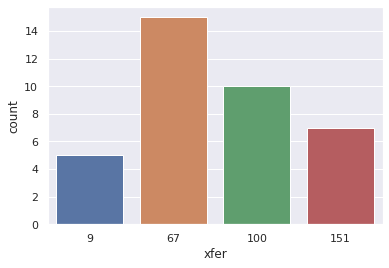

In [3]:
fig = plot_xfer_heatmap(xfers_applied)

# Pair plot of detailed costs

In [33]:
def plot_pair_grid(graph, timestamp):
    data = dict(runtime=[], flops=[], mem_acc=[], num_kernels=[], graph=[])
    
    if not isinstance(graph, list):
        graph = [graph]
    if not isinstance(timestamp, list):
        timestamp = [timestamp]
    
    
    for i, _ in enumerate(graph):
        path = f'../logs/xflowrl/{graph[i]}/{timestamp[i]}/runtime_info.json'
        detailed_costs = load_json(path)

        for e in detailed_costs:
            for k, v in e.items():
                data[k].append(v)
        data['graph'].extend([graph[i]] * len(detailed_costs))

    df = pd.DataFrame.from_dict(data)
    print(df.head())
    g = sns.PairGrid(df, hue='graph')
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    g.add_legend()

    runtime     flops     mem_acc  num_kernels        graph
0  1.385149  1.315675  124.513184        21984  squeezenet1
1  1.363356  1.398332  127.303223        21986  squeezenet1
2  1.383611  1.407999  122.791748        21985  squeezenet1
3  1.414033  1.315675  124.843262        21985  squeezenet1
4  1.353070  1.404698  122.189453        21984  squeezenet1


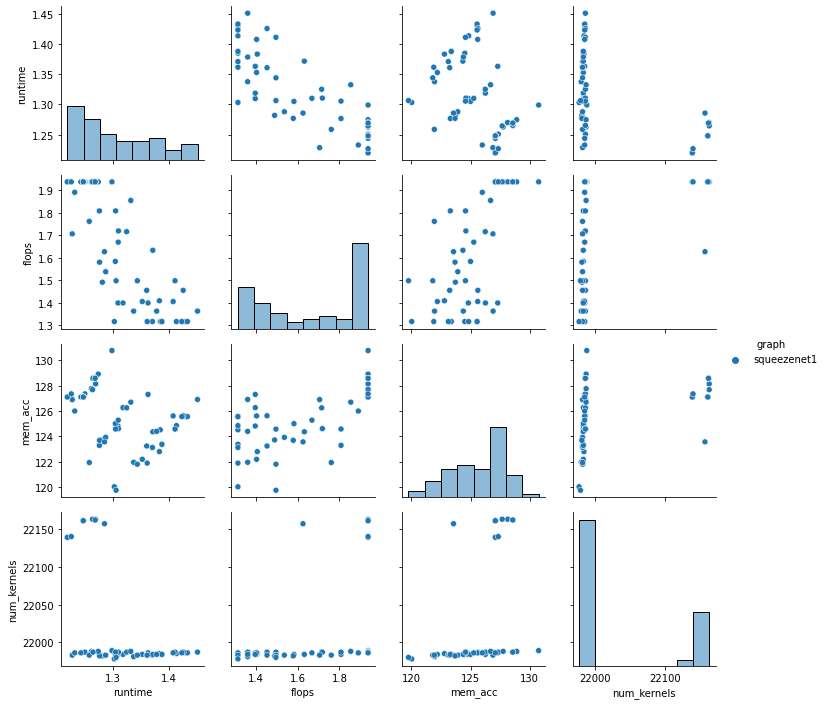

In [34]:
#graphs = ['BERT', 'squeezenet1']
#timestamps = ['20210309-161428', '20210311-184605']
#plot_pair_grid(graphs, timestamps)

plot_pair_grid('squeezenet1', '20210311-184605')

# MB controller training reward line graph

In [50]:
def plot_training_reward(graph, timestamp):
    data = dict(value=[], timestep=[], graph=[])
    if not isinstance(graph, list):
        graph = [graph]
    if not isinstance(timestamp, list):
        timestamp = [timestamp]
    
    for i, _ in enumerate(graph):
        name = 'training_reward.json'
        path = f'../logs/xflowrl_mb_ctrl/{graph[i]}/{timestamp[i]}'
        json_data = load_json(f'{path}/{name}')
        for e in json_data:
            data['timestep'].append(e[1])
            data['value'].append(e[2])
        data['graph'].extend([graph[i]] * len(json_data))

    df = pd.DataFrame.from_dict(data)
    print(df.head())
    sns.set_theme(style='darkgrid')
    ax = sns.lineplot(x='timestep', y='value', data=df, hue='graph')
    ax.set(xlabel='Epochs', ylabel='Average Reward')
    save_figure('mb_ctrl_training_reward', '../plots', ax)

      value  timestep graph
0  2.668699        10  BERT
1  2.668699        20  BERT
2  2.668699        30  BERT
3  7.924578        40  BERT
4  2.668699        50  BERT


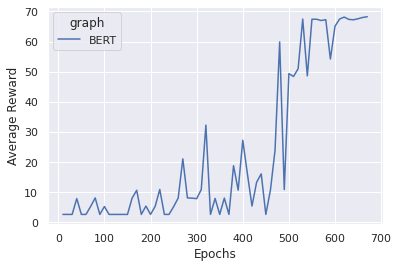

In [51]:
plot_training_reward('BERT', '20210505-163930')

# World model training loss line graph

In [89]:
def plot_training_loss_world_model(graph, timestamp):
    data = dict(value=[], timestep=[], graph=[])
    if not isinstance(timestamp, list):
        timestamp = [timestamp]
    if not isinstance(graph, list):
        graph = [graph]
    
    for i, _ in enumerate(graph):
        name = 'training_loss.json'
        path = f'../logs/xflowrl_mb/{graph[i]}/{timestamp[i]}'
        json_data = load_json(f'{path}/{name}')
        for e in json_data:
            data['timestep'].append(e[1])
            data['value'].append(e[2])
        data['graph'].extend([graph[i]] * len(json_data))

    df = pd.DataFrame.from_dict(data)
    print(df.head())
    sns.set_style('whitegrid', {'axes.grid':False, 'axes.edgecolor':'black', 'axes.linewidth':0, 'xtick.bottom':True, 'ytick.left':True})
    ax = sns.lineplot(x='timestep', y='value', data=df, hue='graph')
    ax.set(xlabel='Epochs', ylabel='Log-likelihood Loss', title='World Model Training Loss')
    ax.legend(frameon=False)
    save_figure('mb_training_loss', '../plots', ax)

      value  timestep graph
0  1.830379        10  BERT
1  1.594241        20  BERT
2  0.857923        30  BERT
3  2.690489        40  BERT
4  0.525178        50  BERT


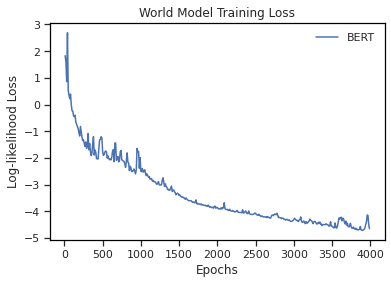

In [90]:
plot_training_loss_world_model('BERT', '20210422-194109')